In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../"))

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from skimage.feature import graycomatrix, graycoprops
from scipy.ndimage import binary_dilation,binary_opening,binary_closing
from skimage.morphology import disk
from utils import load_tiff_image, load_mask
from config import RAW_DATA_PATH

In [3]:
data_path = RAW_DATA_PATH / "data"
mask_path = RAW_DATA_PATH / "masks"

In [4]:
# Load image and mask paths
image_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.tif')]
mask_paths = [os.path.join(mask_path, f) for f in os.listdir(mask_path) if f.endswith('.tif')]

In [5]:
def compute_indices(image):
    nir = image[3]
    red = image[0]
    green = image[1]
    
    ndvi = (nir - red) / (nir + red + 1e-6)
    ndwi = (green - nir) / (green + nir + 1e-6)
    
    return ndvi, ndwi

In [6]:
# Compute texture features
def compute_texture(image):
    grayscale = np.mean(image[:3], axis=0)  # Convert to grayscale
    glcm = graycomatrix(grayscale.astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + 1e-6))
    return contrast, entropy

In [7]:
# Compute cloud coverage percentage
def compute_cloud_coverage(mask_paths):
    cloud_coverage = []
    for mask_path in mask_paths:
        mask = load_mask(mask_path)
        cloud_percentage = np.sum(mask > 0) / mask.size * 100
        cloud_coverage.append(cloud_percentage)
    return cloud_coverage

Cloud Coverage Distribution:
Category
Partially Cloudy    4998
Fully Clouded       4316
Cloud-Free          1259
Name: count, dtype: int64

Detailed Coverage Statistics:
count    10573.000000
mean        62.272809
std         37.624977
min          0.000000
25%         26.935959
50%         72.957230
75%        100.000000
max        100.000000
Name: Coverage_Percent, dtype: float64


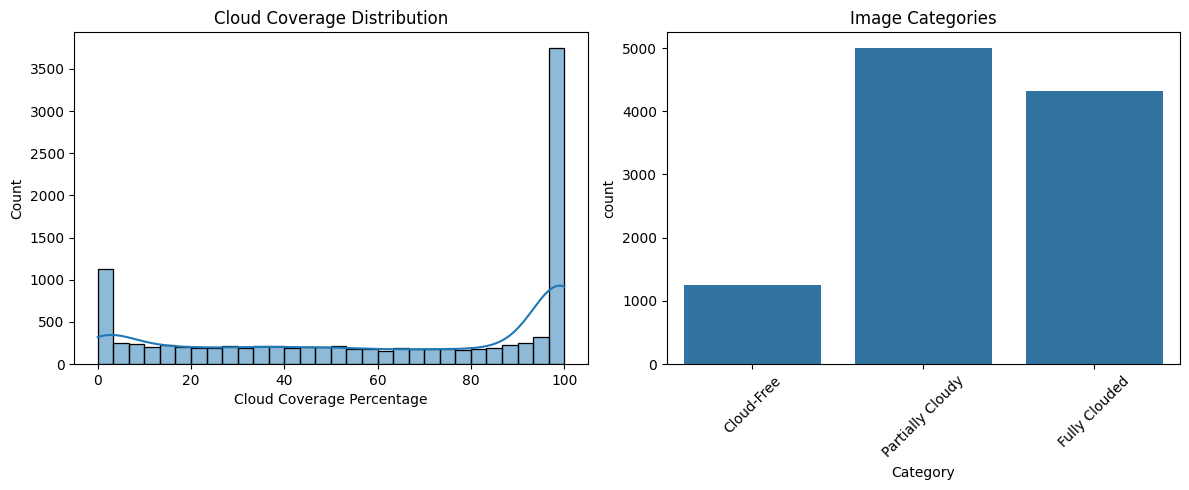

In [8]:
# Calculate cloud coverage statistics
def analyze_cloud_coverage(mask_paths):
    coverage_stats = []
    for mask_path in mask_paths:
        mask = load_mask(mask_path)
        cloud_pixels = np.sum(mask > 0)
        total_pixels = mask.size
        coverage_percent = (cloud_pixels / total_pixels) * 100
        
        # Categorize each image
        if coverage_percent > 90:
            category = "Fully Clouded"
        elif coverage_percent < 5:
            category = "Cloud-Free"
        else:
            category = "Partially Cloudy"
            
        coverage_stats.append({
            'Coverage_Percent': coverage_percent,
            'Category': category
        })
    
    return pd.DataFrame(coverage_stats)

# Analyze coverage
coverage_df = analyze_cloud_coverage(mask_paths)

# Print statistics
print("Cloud Coverage Distribution:")
print(coverage_df['Category'].value_counts())

print("\nDetailed Coverage Statistics:")
print(coverage_df['Coverage_Percent'].describe())

# Plot distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(coverage_df['Coverage_Percent'], bins=30, kde=True)
plt.title('Cloud Coverage Distribution')
plt.xlabel('Cloud Coverage Percentage')

plt.subplot(1, 2, 2)
sns.countplot(data=coverage_df, x='Category', order=["Cloud-Free", "Partially Cloudy", "Fully Clouded"])
plt.title('Image Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Extract features for cloud mask classification
def extract_features(image_paths, mask_paths):
    features = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image = load_tiff_image(img_path)
        mask = load_mask(mask_path)
        
        ndvi, ndwi = compute_indices(image)
        contrast, entropy = compute_texture(image)
        cloud_coverage = np.sum(mask > 0) / mask.size * 100
        
        features.append({
            'NDVI_mean': np.mean(ndvi), 'NDVI_std': np.std(ndvi),
            'NDWI_mean': np.mean(ndwi), 'NDWI_std': np.std(ndwi),
            'Contrast': contrast, 'Entropy': entropy,
            'Cloud_Coverage': cloud_coverage
        })
    return pd.DataFrame(features)

In [10]:
# Function to visualize sample images and masks
def plot_sample_images(image_paths, mask_paths, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    for i, (img_path, mask_path) in enumerate(zip(image_paths[:num_samples], mask_paths[:num_samples])):
        image = load_tiff_image(img_path)
        mask = load_mask(mask_path)
        
        image_rgb = image[:3].transpose(1, 2, 0)
        image_rgb = (image_rgb - image_rgb.min()) / (image_rgb.max() - image_rgb.min())  # Normalize to [0,1]
        
        axes[i, 0].imshow(image_rgb)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")
        
        axes[i, 1].imshow(mask, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Cloud Mask {i+1}")
    plt.show()

   NDVI_mean   NDVI_std  NDWI_mean   NDWI_std     Contrast    Entropy  \
0   0.933800   4.320426  19.504398  11.517459  9790.349082  15.779901   
1   4.221262  13.468921  21.382017  18.109776  8248.707463  15.618400   
2   0.698302   0.245737  15.722183   4.487708  7810.399603  15.545239   
3   0.821891   0.029324  20.709911   3.435667  7070.565328  13.344044   
4   1.736159   1.696883   7.391781   6.573325  9050.652550  15.234157   

   Cloud_Coverage  
0        0.000000  
1        6.036377  
2       26.066971  
3        1.352310  
4       67.124176  


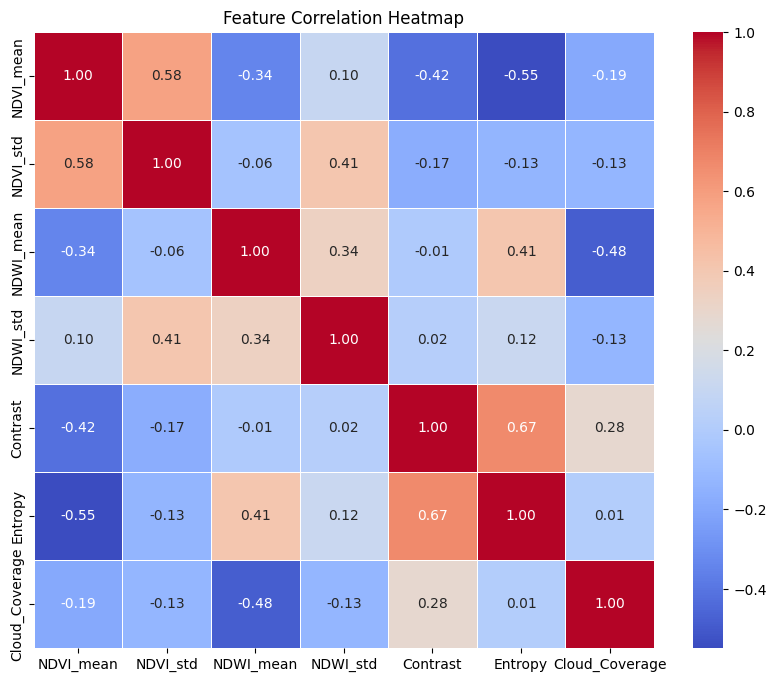

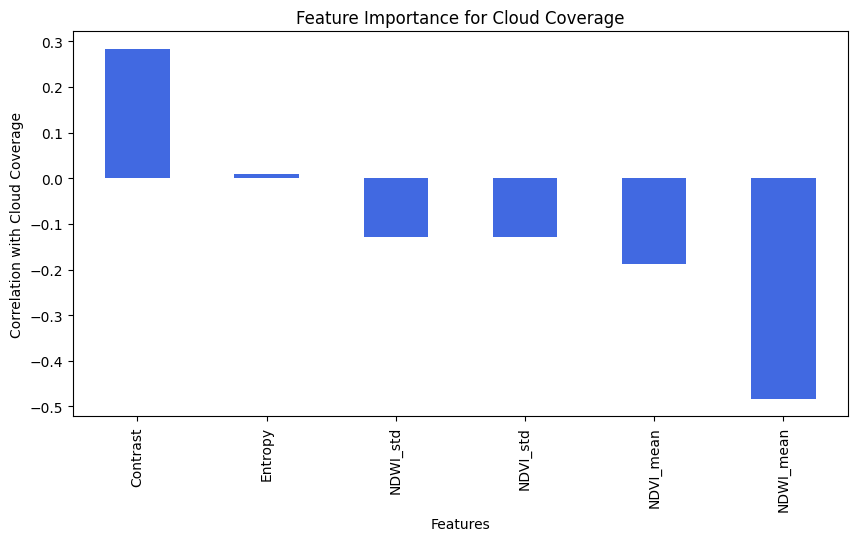

In [11]:
# Extract features
df_features = extract_features(image_paths, mask_paths)
print(df_features.head())

# Compute correlation matrix and plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Plot feature importance (assuming cloud coverage is the target variable)
correlation = df_features.corr()['Cloud_Coverage'].drop('Cloud_Coverage')
correlation.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color='royalblue')
plt.title("Feature Importance for Cloud Coverage")
plt.xlabel("Features")
plt.ylabel("Correlation with Cloud Coverage")
plt.show()

Dice Coefficient: 0.6137


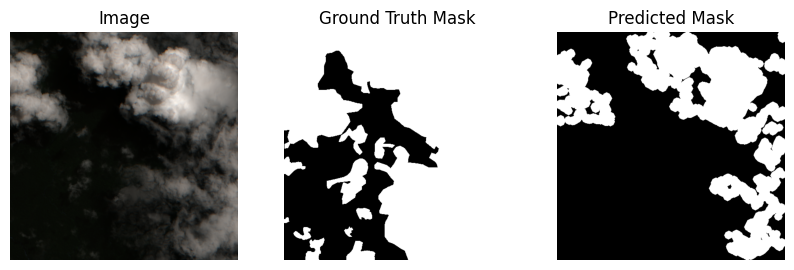

In [12]:
imgae_num = 15
sample_image = load_tiff_image(image_paths[imgae_num])
sample_mask_image = load_mask(mask_paths[imgae_num])

# Compute indices
ndvi, ndwi = compute_indices(sample_image)  # You already have this
red, green, blue, ir = sample_image[0], sample_image[1], sample_image[2], sample_image[3]

# Base cloud score
cloud_score = red + green + blue - ndwi - ndvi

# Normalize
cloud_score = (cloud_score - cloud_score.min()) / (cloud_score.max() - cloud_score.min() + 1e-6)

# Optional: suppress likely rock areas
rock_mask = (ndwi < 0.1) & (ndvi < 0.2) & (cloud_score > 0.5)
cloud_score[rock_mask] *= 0.1  # Reduce rock intensity

veg_mask = ndvi > 0.4
cloud_score[veg_mask] *= 0.1  # Reduce vegetation intensity

water_mask = ndwi > 0.4
cloud_score[water_mask] *= 0.2  # Reduce water intensity

brightness = (red + green + blue) / 3
dark_mask = brightness < 0.2
cloud_score[dark_mask] *= 0.1  # Reduce dark areas

# Final decision
threshold = np.percentile(cloud_score, 90)
predicted_cloud_mask = (cloud_score > threshold).astype(np.uint8)

# Morphological cleanup
predicted_cloud_mask = binary_closing(predicted_cloud_mask, iterations=5)
# predicted_cloud_mask = binary_opening(predicted_cloud_mask, iterations=5)
predicted_cloud_mask = binary_dilation(predicted_cloud_mask, iterations=3, structure=disk(3))




# Dice coefficient
true_mask = sample_mask_image.astype(bool)
predicted_mask = predicted_cloud_mask.astype(bool)
intersection = np.sum(true_mask & predicted_mask)
union = np.sum(true_mask) + np.sum(predicted_mask)
dice_coefficient = (2.0 * intersection) / (union + 1e-6)

print(f"Dice Coefficient: {dice_coefficient:.4f}")

image_rgb = sample_image[:3].transpose(1, 2, 0)
image_rgb = (image_rgb - image_rgb.min()) / (image_rgb.max() - image_rgb.min() + 1e-6)

fig, axes = plt.subplots(1, 3, figsize=(10, 20))
axes[0].imshow(image_rgb)
axes[0].axis('off')
axes[0].set_title(f"Image")

axes[1].imshow(sample_mask_image, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title(f"Ground Truth Mask")

axes[2].imshow(predicted_cloud_mask, cmap='gray', vmin=0, vmax=1)
axes[2].axis('off')
axes[2].set_title(f"Predicted Mask")
plt.show()

# detecting misclassifications using Bands Combinations

In [13]:
def detect_misclassified(image_paths, mask_paths):
    misclassified = []
    correct_predictions = 0
    total_images = len(image_paths)

    for i in range(total_images):
        # Load image and mask
        sample_image = load_tiff_image(image_paths[i])
        sample_mask_image = load_mask(mask_paths[i])

        # Split bands
        red, green, blue, ir = sample_image[0], sample_image[1], sample_image[2], sample_image[3]

        # Compute NDVI & NDWI
        ndvi = (ir - red) / (ir + red + 1e-6)
        ndwi = (green - ir) / (green + ir + 1e-6)
        ndsi = np.zeros_like(ndvi)  # No SWIR available, fill with zeros

        # Base cloud score
        cloud_score = red + green + blue - ndwi - ndvi

        # Normalize
        cloud_score = (cloud_score - cloud_score.min()) / (cloud_score.max() - cloud_score.min() + 1e-6)

        # Suppress non-cloud features
        rock_mask = (ndwi < 0.1) & (ndvi < 0.2) & (cloud_score > 0.5)
        veg_mask = ndvi > 0.4
        water_mask = ndwi > 0.4
        brightness = (red + green + blue) / 3
        dark_mask = brightness < 0.2

        cloud_score[rock_mask] *= 0.1
        cloud_score[veg_mask] *= 0.1
        cloud_score[water_mask] *= 0.2
        cloud_score[dark_mask] *= 0.1

        # Final mask thresholding
        threshold = np.percentile(cloud_score, 90)
        predicted_cloud_mask = (cloud_score > threshold).astype(np.uint8)

        # Morphological cleanup
        predicted_cloud_mask = binary_closing(predicted_cloud_mask, iterations=10)
        predicted_cloud_mask = binary_opening(predicted_cloud_mask, iterations=10)
        predicted_cloud_mask = binary_dilation(predicted_cloud_mask, iterations=3, structure=disk(3))

        # Dice coefficient
        true_mask = sample_mask_image.astype(bool)
        predicted_mask = predicted_cloud_mask.astype(bool)
        intersection = np.sum(true_mask & predicted_mask)
        union = np.sum(true_mask) + np.sum(predicted_mask)
        dice_coefficient = (2.0 * intersection) / (union + 1e-6)

        print(f"Image {i+1}/{total_images} - Dice Coefficient: {dice_coefficient:.4f}")

        # Statistics for heuristic
        mask_coverage = np.mean(sample_mask_image)
        mean_ndvi = np.mean(ndvi)
        mean_ndwi = np.mean(ndwi)
        mean_ndsi = np.mean(ndsi)
        mean_brightness = np.mean(brightness)

        # Heuristic to flag misclassifications
        pred_coverage = np.mean(predicted_cloud_mask)

        over_predicted = pred_coverage > mask_coverage + 0.3
        under_predicted = mask_coverage > pred_coverage + 0.3
        conflict_ndvi = mean_ndvi > 0.5 and pred_coverage > 0.5  
        conflict_ndsi = mean_ndsi < 0.1 and pred_coverage > 0.6 
        conflict_brightness = (mean_brightness < 0.2 or mean_brightness > 0.9) and pred_coverage > 0.5

        suspicious = (
            dice_coefficient <= 0.4 and (
                over_predicted or under_predicted or
                conflict_ndvi or conflict_ndsi or conflict_brightness
            )
        )

        if suspicious:
            misclassified.append(i)
            print(f"--> Potential misclassification at index {i}")
            print(f"    - Dice Coefficient: {dice_coefficient:.4f}")
            print(f"    - Mask Coverage: {mask_coverage:.2f}")
            print(f"    - NDVI: {mean_ndvi:.2f}, NDWI: {mean_ndwi:.2f}, NDSI: {mean_ndsi:.2f}, Brightness: {mean_brightness:.2f}")
        else:
            correct_predictions += 1

    print(f"\n✅ Correct Predictions: {correct_predictions}/{total_images}")
    print(f"❌ Misclassified Images: {len(misclassified)}")

    return misclassified

suspicious_indices = detect_misclassified(image_paths, mask_paths)

Image 1/10573 - Dice Coefficient: 0.0000
--> Potential misclassification at index 0
    - Dice Coefficient: 0.0000
    - Mask Coverage: 0.00
    - NDVI: 0.93, NDWI: 19.50, NDSI: 0.00, Brightness: 937.50
Image 2/10573 - Dice Coefficient: 0.3571
Image 3/10573 - Dice Coefficient: 0.6952
Image 4/10573 - Dice Coefficient: 0.0340
--> Potential misclassification at index 3
    - Dice Coefficient: 0.0340
    - Mask Coverage: 0.01
    - NDVI: 0.82, NDWI: 20.71, NDSI: 0.00, Brightness: 295.03
Image 5/10573 - Dice Coefficient: 0.5321
Image 6/10573 - Dice Coefficient: 0.4766
Image 7/10573 - Dice Coefficient: 0.6104
Image 8/10573 - Dice Coefficient: 0.0000
--> Potential misclassification at index 7
    - Dice Coefficient: 0.0000
    - Mask Coverage: 0.00
    - NDVI: 2.03, NDWI: 27.29, NDSI: 0.00, Brightness: 343.24
Image 9/10573 - Dice Coefficient: 0.0966
Image 10/10573 - Dice Coefficient: 0.4725
Image 11/10573 - Dice Coefficient: 0.2469
--> Potential misclassification at index 10
    - Dice Coeffi

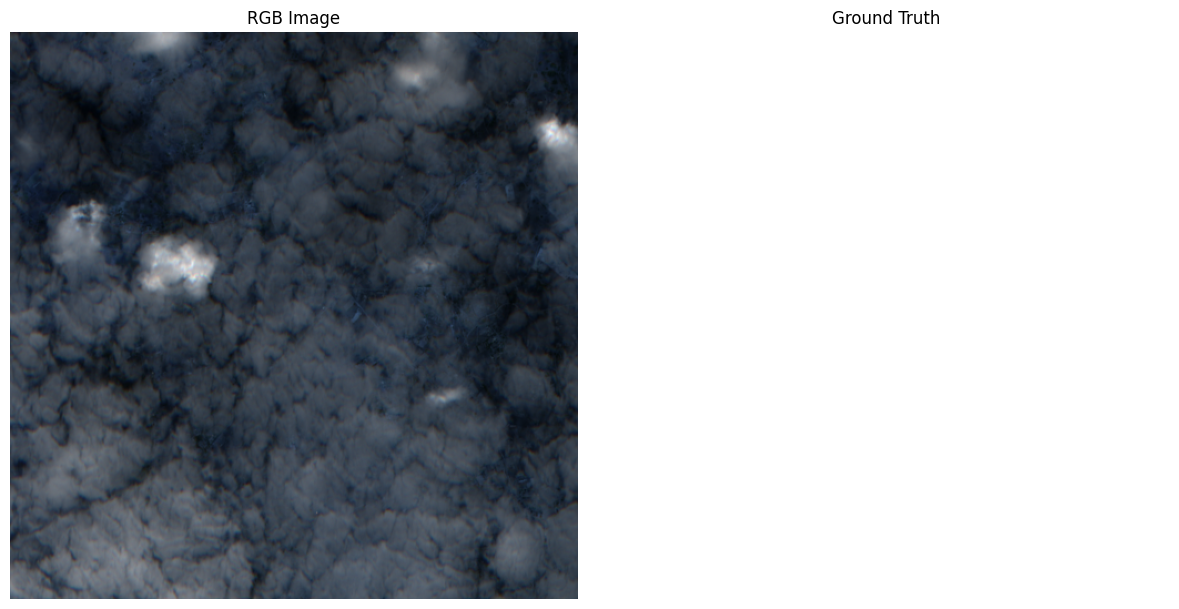

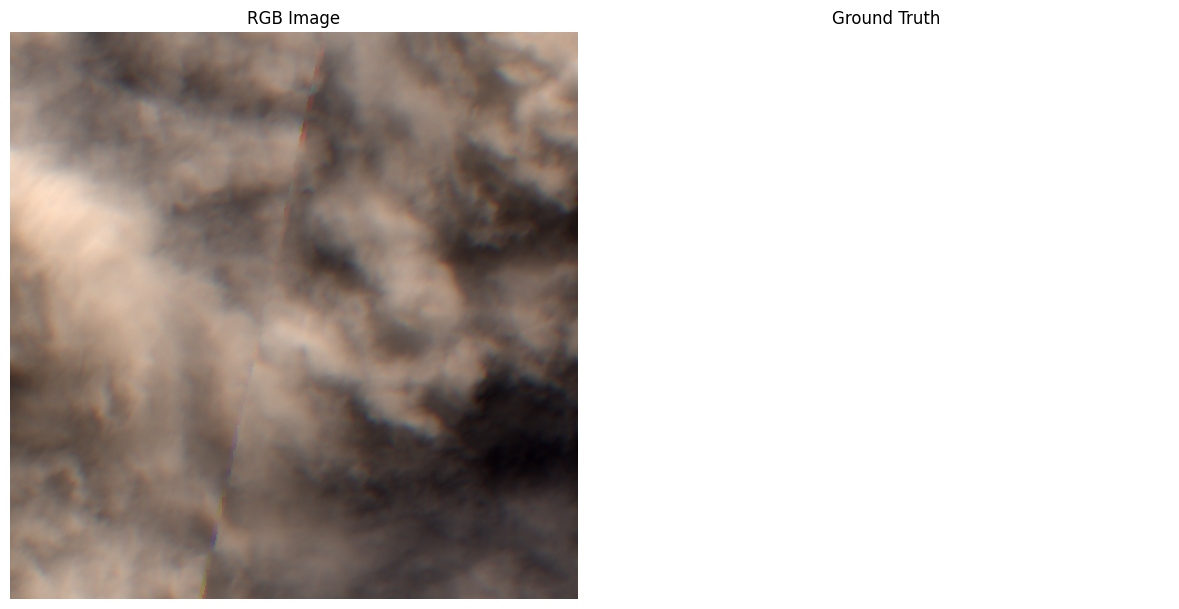

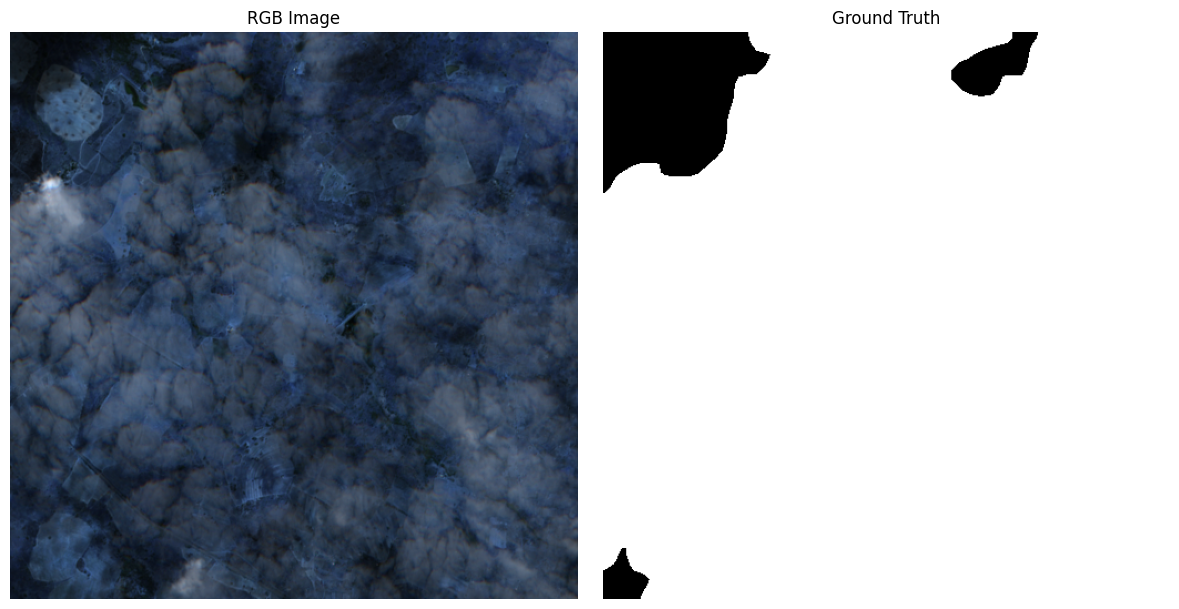

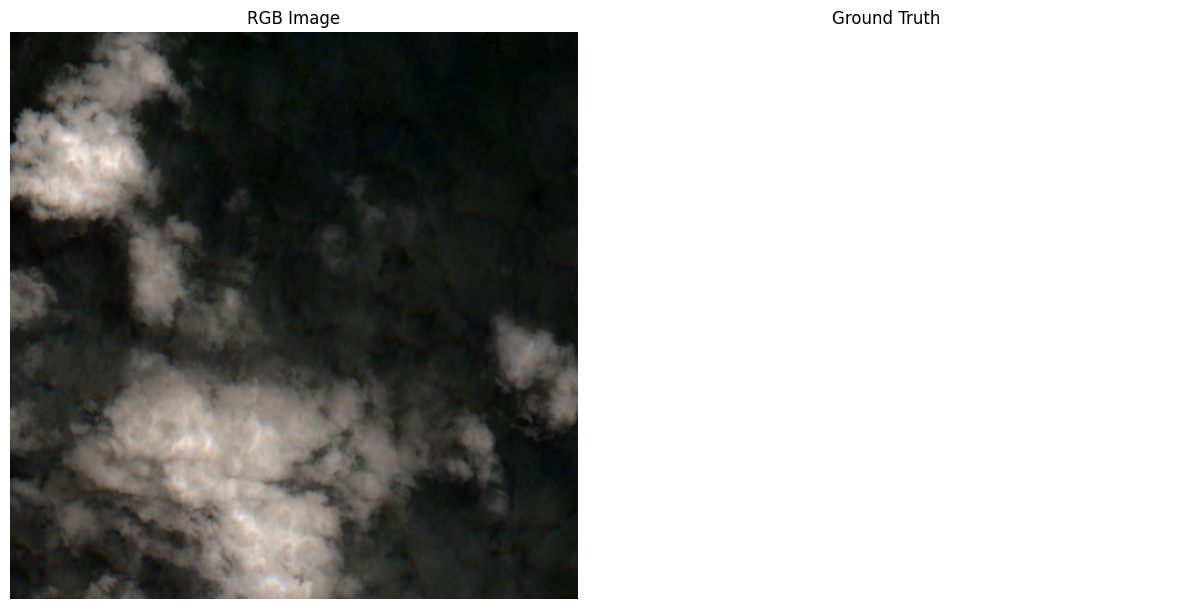

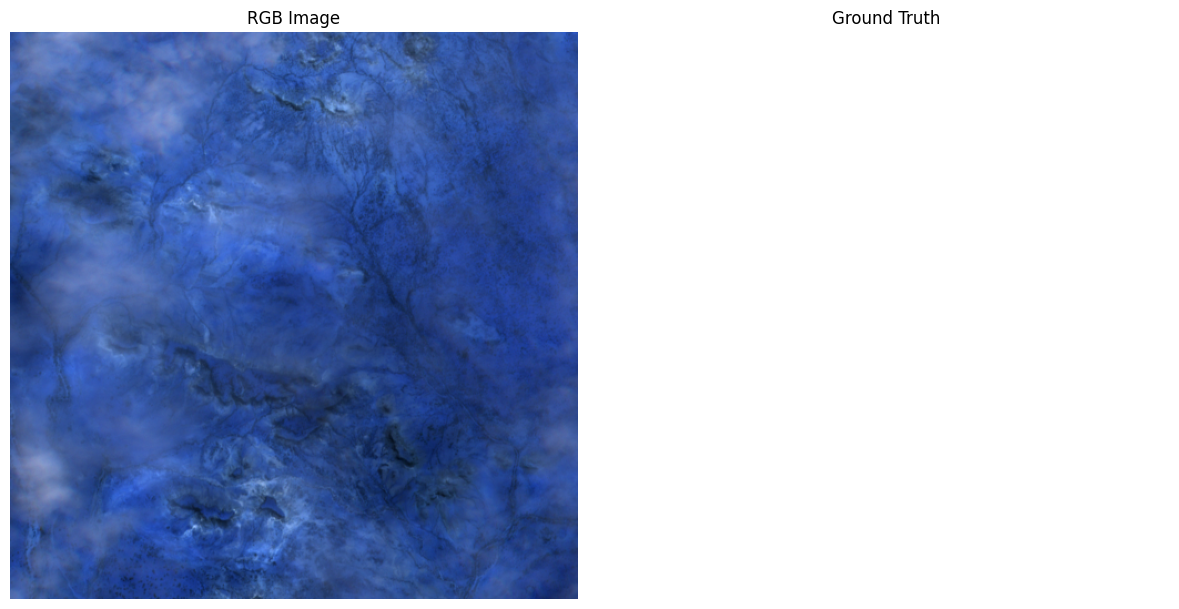

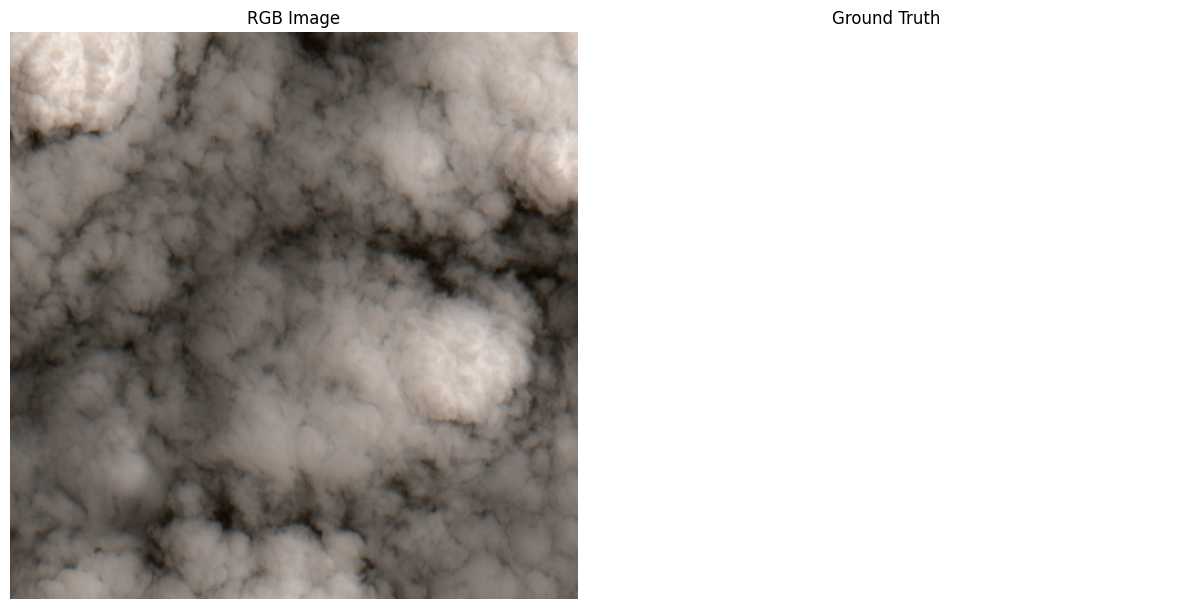

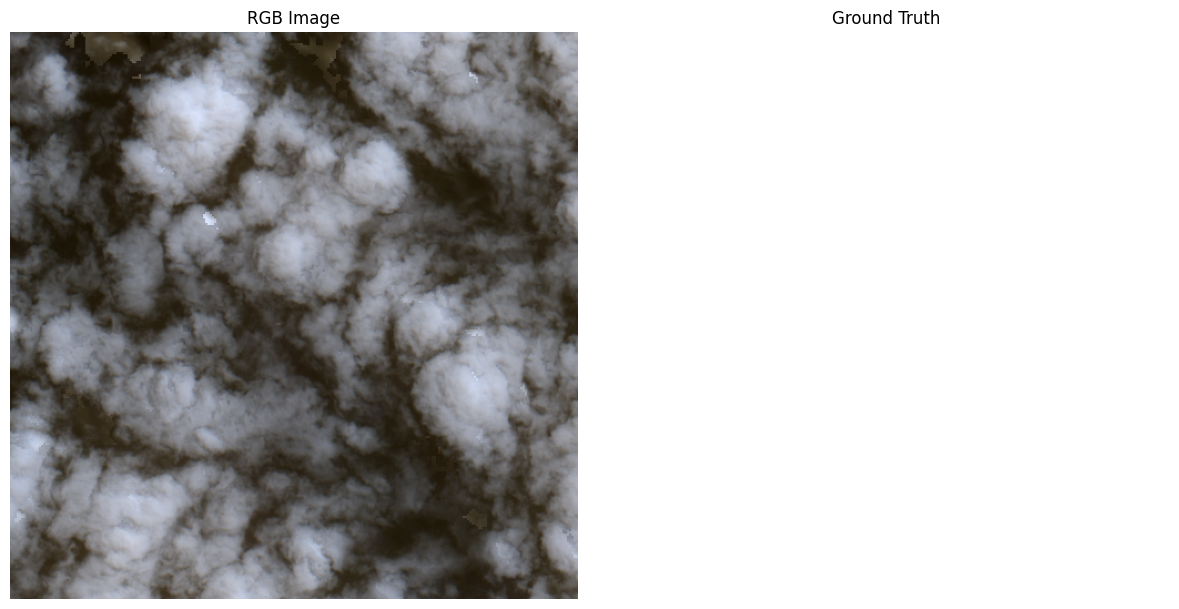

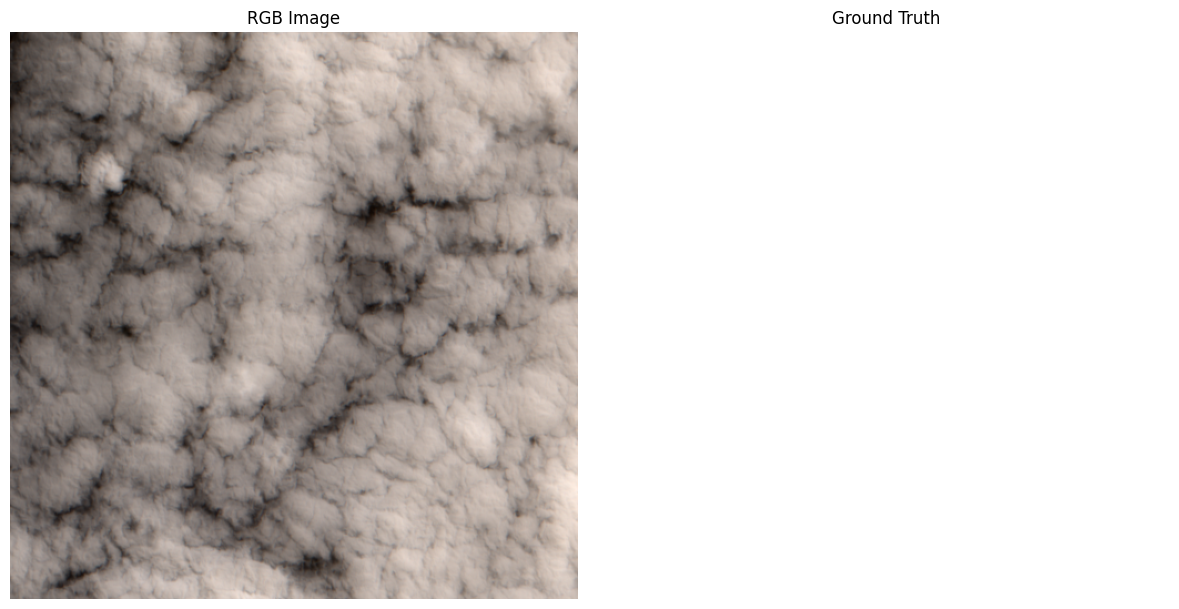

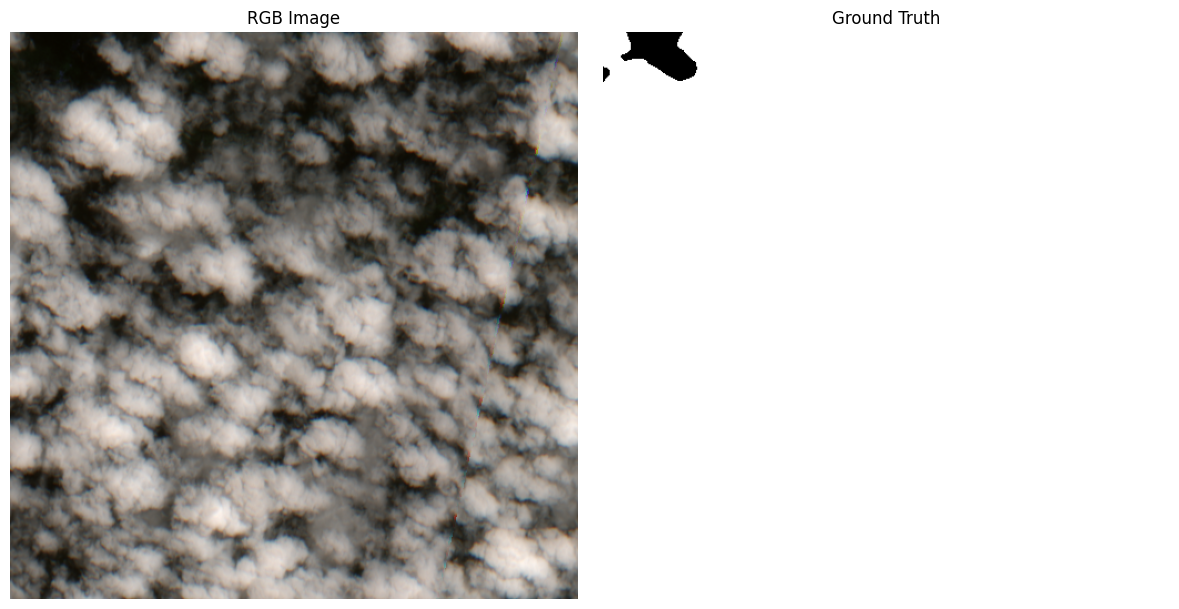

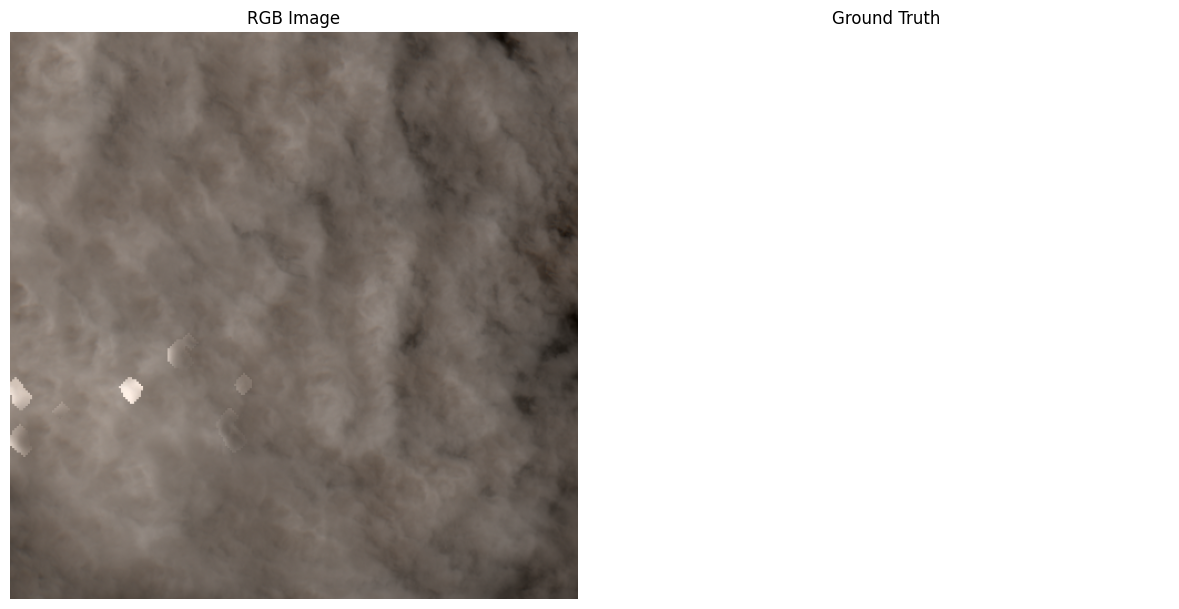

In [14]:
# take 10 random samples from suspicious indices and plot them with their masks
random_indices = random.sample(suspicious_indices, 10)
for i, idx in enumerate(random_indices):
    image = load_tiff_image(image_paths[idx])
    mask = load_mask(mask_paths[idx])

    image_rgb = image[:3].transpose(1, 2, 0)
    image_rgb = (image_rgb - image_rgb.min()) / (image_rgb.max() - image_rgb.min() + 1e-6)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_rgb)
    axes[0].set_title("RGB Image")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()